In [25]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
import imageio

In [26]:
def image_to_np_array(image_path):
    return np.asarray(Image.open(image_path).convert('L'))

def resize_image(image_np_array, shape):
    PIL_image = Image.fromarray(np.uint8(image_np_array)).convert("L")
    PIL_image = PIL_image.resize(shape)
    return np.array(PIL_image)

def plot_image(img: np.array):
    plt.figure(figsize=(6, 6))
    plt.imshow(img.astype('uint8'), cmap="gray")

(1600, 1200)
(800, 600)


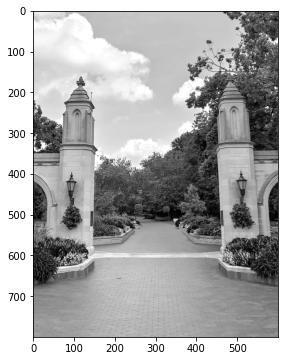

In [27]:
sample_gates = image_to_np_array('sample_gates_resize.jpg')
clock = image_to_np_array('input_clock.jpg')
print(sample_gates.shape)
sample_gates_cropped = resize_image(sample_gates, (600, 800))
print(sample_gates_cropped.shape)
clock_resized = resize_image(clock, (600, 800))
plot_image(sample_gates_cropped)

In [28]:
sample_gates_cropped.shape == clock_resized.shape

True

In [29]:
def fourier_transform(image_np):
    return fftpack.fftshift(fftpack.fft2(image_np)) # np.fft.fftshift(np.fft.fft2(np.float32(image_np)))

def inverse_fourier_transform(fft_image_np):
    return abs(fftpack.ifft2(fftpack.ifftshift(fft_image_np)))

def plot_fourier_image(image_fourier_np):
    fourier_image = (np.log(abs(image_fourier_np))* 255 /np.amax(np.log(abs(image_fourier_np)))).astype(np.uint8)
    plt.figure(figsize=(6, 6))
    plt.imshow(fourier_image.astype('uint8'), cmap="gray")

def save_fft_image(image_fourier_np, filename):
    fourier_image = (np.log(abs(image_fourier_np))* 255 /np.amax(np.log(abs(image_fourier_np)))).astype(np.uint8)
    imageio.imsave(filename, fourier_image)

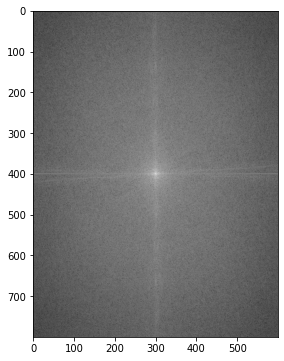

In [30]:
fft_clock = fourier_transform(clock_resized)
fft_sample_gates = fourier_transform(sample_gates_cropped)
plot_fourier_image(fft_sample_gates)
save_fft_image(fft_sample_gates, "sample_gates_fft.png")
save_fft_image(fft_clock, "clock_fft.png")

In [31]:
def fft_pass_filter(fft_image_np, is_high = False, radius = 30):
    eX, eY = radius, radius
    x, y = fft_image_np.shape[1], fft_image_np.shape[0]
    bounding_box = (x/2 - eX/2, y/2 - eY/2, x/2 + eX/2, y/2 + eY/2)
    
    color = 255 if not is_high else 0
    fill  = 0 if not is_high else 255

    filter = Image.new("L", (x, y), color=color) 
    draw = ImageDraw.Draw(filter)
    draw.ellipse(bounding_box, fill=fill)
    return np.array(filter)

In [32]:
fft_clock_low = fft_pass_filter(fft_clock)
fft_clock_high = fft_pass_filter(fft_clock, True)

fft_sg_low = fft_pass_filter(fft_sample_gates)
fft_sg_high = fft_pass_filter(fft_sample_gates, True)

In [33]:
def fft_join_image(fft_input_np, image_1_np, image_2_np):
    final_image = np.full(image_1_np.shape, 255, dtype = complex)
    for i in range(image_1_np.shape[0]):
        for j in range(image_1_np.shape[1]):
            if fft_input_np[i,j] == 0: 
                final_image[i,j] = image_1_np[i,j]
            else: 
                final_image[i,j] = image_2_np[i,j]
    return final_image

In [34]:
fft_clock_low_sg_high = fft_join_image(fft_clock_low, fft_clock, fft_sample_gates)
fft_clock_high_sg_low = fft_join_image(fft_clock_high, fft_clock, fft_sample_gates)

In [35]:
clock_low_sg_high = inverse_fourier_transform(fft_clock_low_sg_high)
clock_high_sg_low = inverse_fourier_transform(fft_clock_high_sg_low)

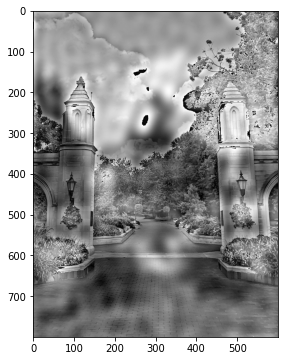

In [36]:
plot_image(clock_low_sg_high)

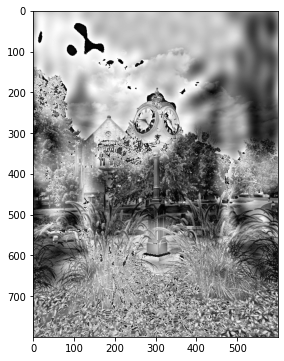

In [37]:
plot_image(clock_high_sg_low)

In [38]:
clock_low_sg_high = Image.fromarray(clock_low_sg_high).convert("L")
clock_low_sg_high.save("Image_1_fft_ifft.jpg")

In [39]:
clock_high_sg_low = Image.fromarray(clock_high_sg_low).convert("L")
clock_high_sg_low.save("Image_2_fft_ifft.jpg")